In [17]:
import torch
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from PIL import Image
import os
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import random
import torch.nn.functional as F
import heapq
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [18]:
"""class TripletDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        
        individuals = os.listdir(root_dir)
        self.class_to_idx = {ind: i for i, ind in enumerate(individuals)} #lie les individus (AD, BS, ...) à un ID
        
        #Pour chaque individu, on prend chaque image et le label correspondant et on les ajoute dans les attributs de classe
        for ind in individuals:
            img_dir =f"{root_dir}/{ind}/images"
            label_dir = f"{root_dir}/{ind}/labels"
            if os.path.exists(img_dir) and os.path.exists(label_dir):
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label_path = os.path.join(label_dir, img_name.replace(".png", ".txt"))
                    if os.path.exists(label_path):
                        self.data.append((img_path, label_path)) #On ajoute une paire avec l'image et les annotations de sa bbox
                        self.labels.append(self.class_to_idx[ind])
        
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.data)

    def read_yolo_label(self, label_path, img_width, img_height):
        with open(label_path, "r") as f:
            lines = f.readlines()
        if not lines:
            return None  # Pas de bounding box trouvée
        
        #On récupère la bbox du visage et pas celle du corps
        face_annotation = None
        for line in lines: 
            if line[0] == "0":  #0 est le label des annotations des visages
                face_annotation = line
        _, x_center, y_center, width, height = map(float, face_annotation.split())
        
        # Conversion des coordonnées normalisées en pixels
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height
        
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)
        
        return (x1, y1, x2, y2)

    def __getitem__(self, idx):
        img_path, label_path = self.data[idx]
        anchor_label = self.labels[idx]
        
        image = Image.open(img_path).convert("RGB")
        bbox = self.read_yolo_label(label_path, image.width, image.height)
    
        if bbox:
            image = image.crop(bbox)
        
        if self.transform:
            anchor_img = self.transform(image)
        
        positive_indices = torch.where(self.labels == anchor_label)[0]
        negative_indices = torch.where(self.labels != anchor_label)[0]
        
        positive_idx = random.choice(positive_indices)
        negative_idx = random.choice(negative_indices)
        
        pos_img_path, pos_label_path = self.data[positive_idx]
        neg_img_path, neg_label_path = self.data[negative_idx]
        
        pos_image = Image.open(pos_img_path).convert("RGB")
        neg_image = Image.open(neg_img_path).convert("RGB")
        
        pos_bbox = self.read_yolo_label(pos_label_path, pos_image.width, pos_image.height)
        neg_bbox = self.read_yolo_label(neg_label_path, neg_image.width, neg_image.height)
        
        if pos_bbox:
            pos_image = pos_image.crop(pos_bbox)
        if neg_bbox:
            neg_image = neg_image.crop(neg_bbox)
        
        if self.transform:
            positive_img = self.transform(pos_image)
            negative_img = self.transform(neg_image)
        
        return anchor_img, positive_img, negative_img"""

'class TripletDataset(Dataset):\n    def __init__(self, root_dir, transform=None):\n        self.root_dir = root_dir\n        self.transform = transform\n        self.data = []\n        self.labels = []\n        \n        individuals = os.listdir(root_dir)\n        self.class_to_idx = {ind: i for i, ind in enumerate(individuals)} #lie les individus (AD, BS, ...) à un ID\n        \n        #Pour chaque individu, on prend chaque image et le label correspondant et on les ajoute dans les attributs de classe\n        for ind in individuals:\n            img_dir =f"{root_dir}/{ind}/images"\n            label_dir = f"{root_dir}/{ind}/labels"\n            if os.path.exists(img_dir) and os.path.exists(label_dir):\n                for img_name in os.listdir(img_dir):\n                    img_path = os.path.join(img_dir, img_name)\n                    label_path = os.path.join(label_dir, img_name.replace(".png", ".txt"))\n                    if os.path.exists(label_path):\n                       

In [19]:
class TripletDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        
        individuals = os.listdir(root_dir)
        self.class_to_idx = {ind: i for i, ind in enumerate(individuals)}
        
        """ for ind in individuals:
            img_dir =f"{root_dir}/{ind}/images"
            label_dir = f"{root_dir}/{ind}/labels"
            if os.path.exists(img_dir) and os.path.exists(label_dir):
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label_path = os.path.join(label_dir, img_name.replace(".png", ".txt"))
                    if os.path.exists(label_path):
                        with open(label_path, "r") as f:
                            lines = f.readlines()
                        if len(lines) != 0:
                            self.data.append((img_path, label_path))
                            self.labels.append(self.class_to_idx[ind])"""

        for ind in individuals:
            #img_dir =f"{root_dir}/{ind}/images"
            #label_dir = f"{root_dir}/{ind}/labels"
            img_dir =f"{root_dir}/{ind}"
            if os.path.exists(img_dir): #and os.path.exists(label_dir):
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    #label_path = os.path.join(label_dir, img_name.replace(".png", ".txt"))
                    #if os.path.exists(label_path):
                     #   self.data.append((img_path, label_path)) #On ajoute une paire avec l'image et les annotations de sa bbox
                     #   self.labels.append(self.class_to_idx[ind])
                    self.data.append(img_path)
                    self.labels.append(self.class_to_idx[ind])
        
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.data)

    def read_yolo_label(self, label_path, img_width, img_height):
        with open(label_path, "r") as f:
            lines = f.readlines()
        if not lines:
            return None  
        
        face_annotation = None
        for line in lines: 
            if line[0] == "0":
                face_annotation = line
        _, x_center, y_center, width, height = map(float, face_annotation.split())
        
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height
        
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)
        
        return (x1, y1, x2, y2)

    def __getitem__(self, idx):
        #img_path, label_path = self.data[idx]
        img_path = self.data[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert("RGB")
        """bbox = self.read_yolo_label(label_path, image.width, image.height)
    
        if bbox:
            image = image.crop(bbox)"""
        
        """plt.imshow(image)
        plt.axis("off")  # Enlever les axes pour une meilleure lisibilité
        plt.title(f"Label: {label}")  # Afficher le label de l'image
        plt.show()
        """
        if self.transform:
            image = self.transform(image)

        return image, label

Evaluate model that have a fully connected layer:

In [20]:
#dataset_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Preprocess"
dataset_path = "C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset"
#model_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/facenet_triplet_loss_5_layers_fc.pth"
model_path = "C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset/facenet_triplet_loss_10_layers_fc.pth"

transform = transforms.Compose([
    transforms.Resize((160, 160)), #redimensionne en une image (160,160)
    transforms.ToTensor(), #convertit l'image en tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #normalise chaque canal de couleur RGB (passe de [0,1] -> [-1,1]
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#num_classes = len(os.listdir("C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Preprocess/train"))
num_classes = len(os.listdir("C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset/train"))
print(os.listdir("C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset/train"))
facenet = InceptionResnetV1(pretrained='vggface2', classify=False)
facenet.fc = torch.nn.Linear(512, num_classes)
# Charger les poids du modèle entraîné
facenet.load_state_dict(torch.load(model_path, map_location=device))
facenet = facenet.to(device)
facenet.eval()  # Mettre le modèle en mode évaluation

train_dataset = TripletDataset(f"{dataset_path}/train", transform=transform)
val_dataset = TripletDataset(f"{dataset_path}/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, facenet.parameters()), lr=0.001)


['FANA', 'FANLE', 'FANWA', 'FLANLE', 'FOAF', 'JEJE', 'JIRE', 'JOYA', 'PELEY', 'TUA']


In [21]:
def predict_image_with_fc(image_path, model, transform, device):
    # Charger l'image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Ajouter une dimension batch

    # Faire la prédiction
    with torch.no_grad():
        logits = model(image)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    return predicted_class, probabilities.cpu().numpy()

Total Precision: 0.5628


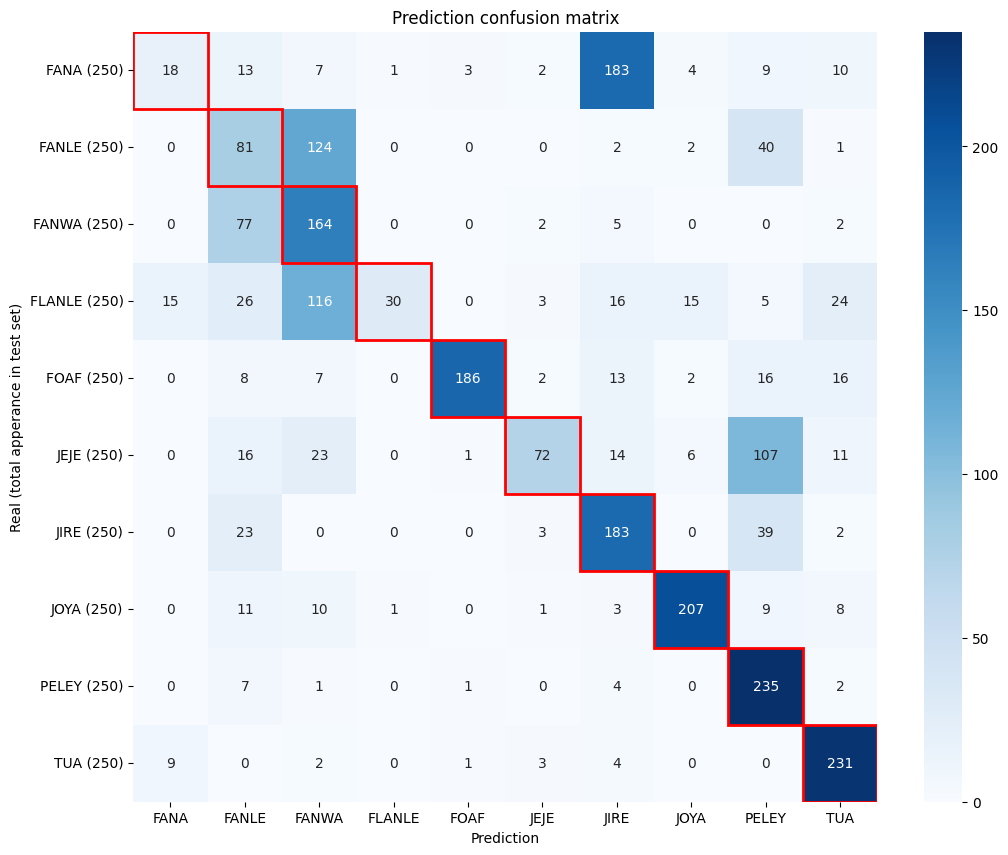

In [22]:
#test_dataset = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Test_set"
test_dataset = "C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset/test"
imgs = os.listdir(test_dataset)

class_names = list(train_dataset.class_to_idx.keys())
num_classes = len(class_names)

# Initialiser les compteurs
true_positive = {indiv: 0 for indiv in class_names}
false_positive = {indiv: 0 for indiv in class_names}
false_negative = {indiv: 0 for indiv in class_names}
total_appearance = {indiv: 0 for indiv in class_names}

# Matrice de confusion
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

for img in imgs:
    image_path = f"{test_dataset}/{img}"

    # Prédiction du modèle
    predicted_label, _ = predict_image_with_fc(image_path, facenet, transform, device)
    predicted_identity = class_names[predicted_label]

    # Identité réelle (extraite du nom du fichier)
    #real_identity = img[:2]
    real_identity = img.split("_")[0]

    # Mettre à jour les compteurs
    total_appearance[real_identity] += 1

    real_idx = class_names.index(real_identity)
    pred_idx = predicted_label

    confusion_matrix[real_idx, pred_idx] += 1

    if predicted_identity == real_identity:
        #print(img)
        true_positive[real_identity] += 1
    else:
        false_positive[predicted_identity] += 1
        false_negative[real_identity] += 1

"""print(false_negative)
print(false_positive)
print(true_positive)
"""
## Calcul de la précision totale
total_tp = sum(true_positive.values())
total_fp = sum(false_positive.values())
precision_total = total_tp / (total_tp + total_fp)

print("==================")
print(f"Total Precision: {precision_total:.4f}")

y_label = [f"{indiv} ({total_appearance[indiv]})"for indiv in class_names]
# Affichage de la heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=y_label)

# Ajouter un cadre rouge autour de la diagonale
for i in range(len(class_names)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))
plt.xlabel("Prediction")
plt.ylabel("Real (total apperance in test set)")
plt.title("Prediction confusion matrix")
plt.show()


Evaluate model that have return an embedding:

In [ ]:
#dataset_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Preprocess"

#model_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/facenet_triplet_loss_5_layers2.pth"
model_path = "C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset/facenet_triplet_loss_5_layers_fc.pth"
transform = transforms.Compose([
    transforms.Resize((160, 160)), #redimensionne en une image (160,160)
    transforms.ToTensor(), #convertit l'image en tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #normalise chaque canal de couleur RGB (passe de [0,1] -> [-1,1]
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
facenet = InceptionResnetV1(pretrained='vggface2', classify=False)

# Charger les poids du modèle entraîné
facenet.load_state_dict(torch.load(model_path, map_location=device))
facenet = facenet.to(device)
facenet.eval()  # Mettre le modèle en mode évaluation

train_dataset = TripletDataset(f"{dataset_path}/train", transform=transform)
val_dataset = TripletDataset(f"{dataset_path}/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, facenet.parameters()), lr=0.001)

RuntimeError: Error(s) in loading state_dict for InceptionResnetV1:
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 

In [5]:
# Fonction pour obtenir l'embedding d'une image
def get_embedding(model, img_tensor):
    with torch.no_grad():
        embedding = model(img_tensor)
    return F.normalize(embedding, p=2, dim=1)  # Normalisation L2

def get_most_predicted_class(labels):
    counter = {}
    for label in labels:
        if label in counter:
            counter[label] += 1
        else:
            counter[label] = 1
    return max(counter, key=counter.get)

# Précalculer et stocker les embeddings du dataset
def compute_and_store_embeddings(dataset, model, transform, device):
    stored_embeddings = []
    for img_path, label_path in dataset.data:
        image = Image.open(img_path).convert("RGB")
        bbox = dataset.read_yolo_label(label_path, image.width, image.height)

        if bbox:
            image = image.crop(bbox)

        img_tensor = transform(image).unsqueeze(0).to(device)
        embedding = get_embedding(model, img_tensor)
        label = dataset.labels[dataset.data.index((img_path, label_path))]

        stored_embeddings.append((embedding, label))

    return stored_embeddings

# Comparer un embedding avec ceux déjà calculés
def compare_with_stored_embeddings(input_embedding, stored_embeddings, k=5):
    distances = []
    for stored_embedding, label in stored_embeddings:
        distance = F.pairwise_distance(input_embedding, stored_embedding).item()
        distances.append((distance, label))

    # Trouver les k plus proches voisins
    k_nearest = heapq.nsmallest(k, distances, key=lambda x: x[0])

    # Récupérer les labels des k voisins
    k_labels = [label for _, label in k_nearest]
    print(k_labels)

    # Trouver la classe majoritaire
    predicted_label = get_most_predicted_class(k_labels)

    return predicted_label, k_nearest[0][0]  # Retourne la classe prédite et la plus petite distance

def predict_face_without_fc(img_path, facenet, stored_embeddings):
    img = Image.open(img_path).convert("RGB")

    # Appliquer les transformations
    transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)
    input_embedding = get_embedding(facenet, img_tensor)

    # Comparer avec les embeddings stockés
    return compare_with_stored_embeddings(input_embedding, stored_embeddings, 1)

# Exemple d'utilisation :
# stored_embeddings = compute_and_store_embeddings(train_dataset, facenet, transform, device)
# predict_face('chemin/vers/image.jpg', facenet, train_dataset, stored_embeddings)


In [17]:
stored_embeddings = compute_and_store_embeddings(train_dataset, facenet, transform, device)

In [ ]:
#test_dataset = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Test_set"
test_dataset = "C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset/test"
imgs = os.listdir(test_dataset)
print(train_dataset.class_to_idx.keys())

true_positive = {} # Classifié comme étant X et c'est X
false_positive = {} # On dit que c'est X mais c'est faux
false_negative = {} # On a dit que c'est quelqu'un d'autre que X alors que c'est X 
total_appearance = {}
for indiv in list(train_dataset.class_to_idx.keys()): 
    true_positive[indiv] = 0
    false_positive[indiv] = 0
    false_negative[indiv] = 0
    total_appearance[indiv] = 0

for img in imgs: 
    image_path = f"{test_dataset}/{img}"
    predicted_label, min_distance = predict_face_without_fc(image_path, facenet, stored_embeddings)
    predicted_identity = list(train_dataset.class_to_idx.keys())[predicted_label]
    real_identity = img[:2]
    print(real_identity)
    print("==================")
    total_appearance[real_identity] += 1
    if predicted_identity == real_identity: 
        true_positive[predicted_identity] += 1
    else: 
        false_positive[predicted_identity] += 1
        false_negative[real_identity] += 1

for indiv in list(train_dataset.class_to_idx.keys()): 
    print("==================")
    print(indiv)
    print(total_appearance[indiv])
    print(true_positive[indiv])

dict_keys(['AD', 'BL', 'BS', 'DK', 'IV', 'JJ', 'KG', 'KM', 'KR', 'LM', 'MG', 'MK', 'MM', 'MZ', 'NJ', 'NR', 'PD', 'TC', 'TS', 'TT'])
[tensor(0)]
AD
[tensor(3)]
DK
[tensor(8)]
KR
[tensor(17)]
TC
[tensor(18)]
TS
AD
1
1
BL
0
0
BS
0
0
DK
1
1
IV
0
0
JJ
0
0
KG
0
0
KM
0
0
KR
1
1
LM
0
0
MG
0
0
MK
0
0
MM
0
0
MZ
0
0
NJ
0
0
NR
0
0
PD
0
0
TC
1
1
TS
1
1
TT
0
0


In [46]:
print(sum(true_positive.values()))

5
